# MURIL (Multilingual Representations for Indic Languages)


<font size="3">
In this notebook I try to train model using MURIL pretrained model combined with Hugging Face and Keras.

But what is MURIL? MURIL (Khanuja et al)(@simrankhanuja) is a multilingual LM specifically built for Indic Languages. Read the full paper [here](https://arxiv.org/pdf/2103.10730.pdf)
</font>


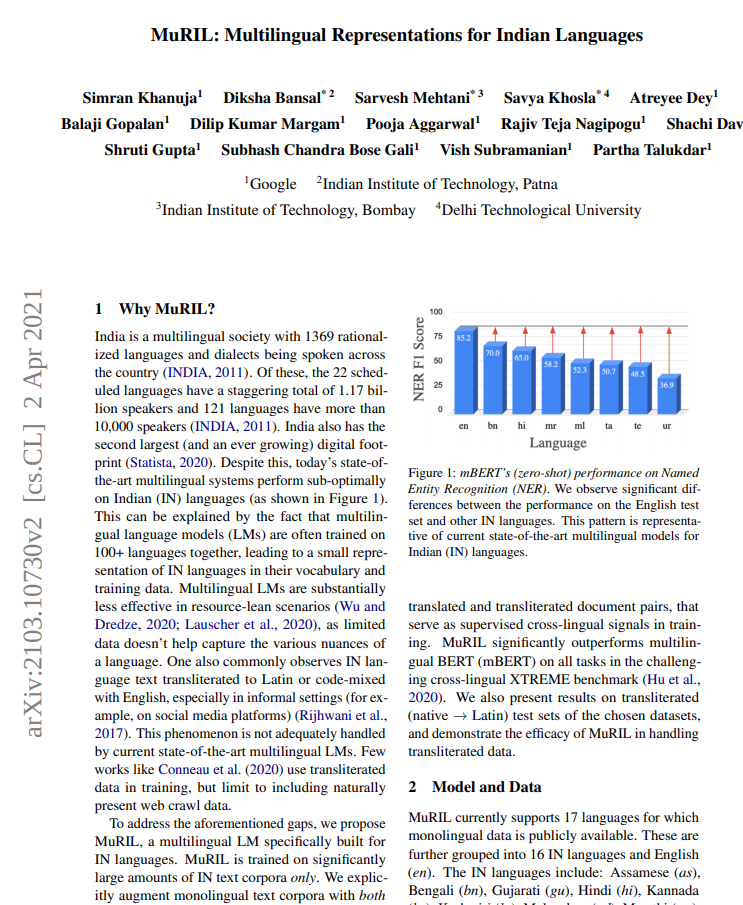

## References



1. This wonderful [notebook](https://github.com/huggingface/notebooks/blob/master/examples/question_answering.ipynb) by HuggingFace 
    
2. Keras Text extraction with Bert [Link](https://keras.io/examples/nlp/text_extraction_with_bert/)


## Stack

1. Pandas for Data Preprocessing

2. tf.data from Tensorflow for Data Pipelines

3. Hugging Face for pretrained model and tokenizer

4. MURIL as the pretrained model

5. Keras for Model training

6. Weights and biases for experiment tracking

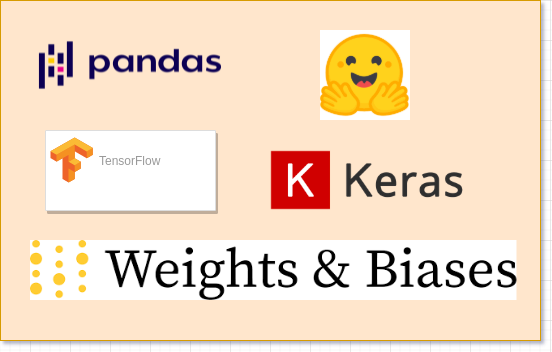

# Table of Contents

1. [Imports](#section1)
2. [Configuration](#section2)
3. [Dataset split](#section3)
4. [Setting Tokenizer](#section4)
5. [Dataset Pipeline](#section5)
6. [Postprocessing Pipeline](#section6)
7. [Creating Dataset](#section7)
8. [Creating Model](#section8)
9. [Model Training](#section9)
10. [Make Predictions on Test Set](#section10)

<a id="section1"></a>
## Imports


In [ ]:

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from transformers import AutoTokenizer
from transformers import TFAutoModel

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import logging


<a id="section2"></a>
## Configuration

In [ ]:
config = {
    'seed' : 42,
    'model': '../input/murilbertcased',
    'group': 'MURIL',
    
    'batch_size': 16,
    'max_length': 384,
    'doc_stride': 128,
    
    'device' : 'GPU',
    'epochs' : 10,
    'n_best_scores': 20,
    'max_answer_length': 75,
    'test_size' : 0.15,
    'lr': 3e-5,
    'use_transfer_learning' : False,
    
    'use_wandb': True,
    'wandb_mode' : 'offline',
}

In [ ]:
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
# Creating a logger 📃
def init_logger(log_file:str ='training.log'):
    
    # Specify the format 
    formatter = logging.Formatter('%(levelname)s:%(name)s:%(message)s')
    
    # Create a StreamHandler Instance
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.DEBUG)
    stream_handler.setFormatter(formatter)
    
    # Create a FileHandler Instance
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    
    # Create a logging.Logger Instance
    logger = logging.getLogger('Chaii-MURIL')
    logger.setLevel(logging.DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger


LOGGER = init_logger()
LOGGER.info("Logger Initialized")

seed_everything()
LOGGER.info("Seed Setting done")


In [ ]:
# To make this work with TPU

def get_device(device):
    if device == 'TPU':
        try: # detect TPUs
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
            strategy = tf.distribute.TPUStrategy(tpu)
        except ValueError: # detect GPUs
            print('Cannot initialize TPU')
    if device == 'GPU':
        strategy = tf.distribute.MirroredStrategy() 

    print("Number of accelerators: ", strategy.num_replicas_in_sync)
    return strategy

strategy= get_device(config['device'])
config['batch_size'] = config['batch_size'] * strategy.num_replicas_in_sync

LOGGER.info("Effective batch size is " + str(config['batch_size']))


In [ ]:
#Intialize wandb run

if config['use_wandb']:
    import wandb
    from wandb.keras import WandbCallback
    from kaggle_secrets import UserSecretsClient
    os.environ["WANDB_MODE"] = "offline"

    if config['wandb_mode'] == 'offline':
        os.environ["WANDB_MODE"] = "offline"
        key='X'*40
        wandb.login(key=key)
    else:
        user_secrets = UserSecretsClient()
        wandb_api = user_secrets.get_secret("wandb_api")
        wandb.login(key=wandb_api)

    run = wandb.init(project='chaii', 
                     group =config['group'], 
                     job_type='train',
                     config = config)

    LOGGER.info("Wandb is initialized")


<a id="section3"></a>
## Dataset Split

In [ ]:
df = pd.read_csv('../input/chaii-hindi-and-tamil-question-answering/train.csv', encoding='utf-8')
df.head()

In [ ]:
df.language.value_counts(normalize=True)*100

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df, 
                                      shuffle=True, 
                                      random_state=config['seed'], 
                                      test_size=config['test_size'], 
                                      stratify=df['language'].values)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_train.to_csv('df_train.csv', index=False)
df_valid.to_csv('df_valid.csv', index=False)

LOGGER.info("Data read from disk")

In [ ]:
if config['use_wandb']:
    artifact =  wandb.Artifact(name="folds", type="dataset")
    artifact.add_file('./df_train.csv')
    artifact.add_file('./df_valid.csv')

    LOGGER.info("Logging folds.csv to W&B Artifacts")
    wandb.log_artifact(artifact)


<a id="section4"></a>
## Setting Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config['model'])
print(tokenizer)

LOGGER.info('Tokenizer loaded')

<a id="section5"></a>
## Dataset Pipelines

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:

class ChaiiDataset:
    def __init__(self, max_length, stride, tokenizer):
        self.max_length = max_length
        self.doc_stride = stride
        self.pad_on_right = tokenizer.padding_side == "right"
        self.tokenizer = tokenizer
    

    def run_tokenizer(self, data):
        tokenized_data = self.tokenizer(
        list(data["question" if self.pad_on_right else "context"].values),
        list(data["context" if self.pad_on_right else "question"].values),
        truncation="only_second" if self.pad_on_right else "only_first",
        max_length=self.max_length,
        stride=self.doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
        )

        return tokenized_data

    def prepare_train_features(self, train_data):
        tokenized_train_data = self.run_tokenizer(train_data)

        sample_mapping = tokenized_train_data.pop("overflow_to_sample_mapping")
        offset_mapping = tokenized_train_data.pop("offset_mapping")

        tokenized_train_data["start_positions"] = []
        tokenized_train_data["end_positions"] = []


        for i, offsets in tqdm(enumerate(offset_mapping)):
            # We will label impossible answers
            # with the index of the CLS token.
            input_ids = tokenized_train_data["input_ids"][i]
            cls_index = input_ids.index(self.tokenizer.cls_token_id)

            # Grab the sequence corresponding 
            # to that example (to know what is 
            # the context and what is the question).
            sequence_ids = tokenized_train_data.sequence_ids(i)

            # One example can give 
            # several spans, this is the 
            # index of the example containing 
            # this span of text.
            
            sample_index = sample_mapping[i]
            answers = list(train_data["answer_text"].values)[sample_index]
            
            # If no answers are given,
            # set the cls_index as answer.
            if len(train_data["answer_start"]) == 0:
                tokenized_train_data["start_positions"].append(cls_index)
                tokenized_train_data["end_positions"].append(cls_index)
            else:
                # Start/end character index 
                # of the answer in the text.
                start_char = list(train_data["answer_start"].values)[sample_index]
                end_char = start_char + len(answers)
                
                # Start token index of the 
                # current span in the text.
                token_start_index = 0
                while sequence_ids[token_start_index] != (1 if self.pad_on_right else 0):
                    token_start_index += 1

                # End token index of the 
                # current span in the text.
                token_end_index = len(input_ids) - 1
                while sequence_ids[token_end_index] != (1 if self.pad_on_right else 0):
                    token_end_index -= 1

                # Detect if the answer is out of span 
                # (in which case this 
                # feature is labeled with the CLS index).
                if not (offsets[token_start_index][0] <= start_char 
                        and offsets[token_end_index][1] >= end_char):
                    tokenized_train_data["start_positions"].append(cls_index)
                    tokenized_train_data["end_positions"].append(cls_index)
                else:
                    # Otherwise move the token_start_index 
                    # and token_end_index to the two ends of the answer.
                    # Note: we could go after the last offset 
                    # if the answer is the last word (edge case).
                    while token_start_index < len(offsets) \
                        and offsets[token_start_index][0] <= start_char:
                        token_start_index += 1
                    tokenized_train_data["start_positions"].append(token_start_index - 1)
                    while offsets[token_end_index][1] >= end_char:
                        token_end_index -= 1
                    tokenized_train_data["end_positions"].append(token_end_index + 1)

        return tokenized_train_data


    def prepare_eval_features(self, eval_data):
        tokenized_eval_data = self.run_tokenizer(eval_data)
        sample_mapping = tokenized_eval_data.pop("overflow_to_sample_mapping")

        # We keep the example_id that gave 
        # us this feature and we will 
        # store the offset mappings.
        tokenized_eval_data["example_id"] = []

        for i in tqdm(range(len(tokenized_eval_data["input_ids"]))):
            # Grab the sequence corresponding to that 
            # example (to know what is the context 
            # and what is the question).
            sequence_ids = tokenized_eval_data.sequence_ids(i)
            context_index = 1 if self.pad_on_right else 0

            # One example can give several spans,
            # this is the index of the example 
            # containing this span of text.
            sample_index = sample_mapping[i]
            tokenized_eval_data["example_id"].append(eval_data["id"].values[sample_index])

            # Set to None the offset_mapping 
            # that are not part of the context 
            # so it's easy to determine if a token
            # position is part of the context or not.
            tokenized_eval_data["offset_mapping"][i] = [
                (o if sequence_ids[k] == context_index else None)
                for k, o in enumerate(tokenized_eval_data["offset_mapping"][i])
            ]

        return tokenized_eval_data

    def prepare_tf_data_pipeline(self, data, batch_size = 16, type='train'):
        
        if type=='train':
            tokenized_data = self.prepare_train_features(data)
        else:
            tokenized_data = self.prepare_eval_features(data)

        input_ids = tokenized_data['input_ids']
        token_type_ids = tokenized_data['token_type_ids']
        attention_mask = tokenized_data['attention_mask']

        def map_func(X_ids, 
                     X_tts, 
                     X_att, 
                     labels_s, 
                     labels_e):
            return {'input_ids':X_ids, 
                    'token_type_ids':X_tts, 
                    'attention_mask': X_att}, \
                    {'start_positions': labels_s, 
                     'end_positions': labels_e}

        def map_func_eval(X_ids, 
                          X_tts, 
                          X_att):
            return {'input_ids':X_ids, 
                    'token_type_ids':X_tts, 
                    'attention_mask': X_att}

        
        if type=='train':

            start_positions = tokenized_data['start_positions']
            end_positions =  tokenized_data['end_positions']

            dataset_train_raw = tf.data.Dataset.from_tensor_slices((input_ids,token_type_ids,
                                                                    attention_mask, 
                                                                    start_positions,  
                                                                    end_positions))
            
            dataset_train = dataset_train_raw.map(map_func) \
                            .shuffle(1000) \
                            .batch(batch_size, drop_remainder=True) \
                            .prefetch(buffer_size=AUTOTUNE) 
            return dataset_train


        if type == 'eval':
            dataset_eval_raw = tf.data.Dataset.from_tensor_slices((input_ids,
                                                    token_type_ids,  
                                                    attention_mask))
            dataset_eval = dataset_eval_raw.map(map_func_eval) \
                            .batch(batch_size)
                
            return dataset_eval, tokenized_data       



<a id="section6"></a>
## Postprocessing Pipeline

In [ ]:
        
def postprocess(raw_dataframe, features, pred_start, pred_end):
    postprocessed_predictions = {}
    dict_local = {}

    for index, item in enumerate(features['example_id']):
        if item not in dict_local:
            dict_local[item] = [index]
        else:
            dict_local[item].append(index)


    for key, value in dict_local.items():
        valid_answers = []
        min_null_score = None
        context = raw_dataframe[raw_dataframe['id'] == key]['context'].values[0]

        for indx in value:
            start = pred_start[indx]
            end = pred_end[indx]

            offset_mapping = features["offset_mapping"][indx]

            # Update minimum null prediction.
            cls_index = features["input_ids"][indx] \
                        .index(tokenizer.cls_token_id)


            feature_null_score = start[cls_index] + end[cls_index]
            if min_null_score is None \
                or min_null_score < feature_null_score:
                min_null_score = feature_null_score


            # Go through all possibilities 
            # for the `n_best_size` greater start and end.

            start_indexes = np.argsort(start)[-1 : -config['n_best_scores'] - 1 : -1].tolist()
            end_indexes = np.argsort(end)[-1 : -config['n_best_scores'] - 1 : -1].tolist()


            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers,
                    # either because the indices are 
                    # out of bounds or correspond
                    # to part of the input_ids 
                    # that are not in the context.
                    
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers 
                    # with a length that is 
                    # either < 0 or > max_answer_length.
                    if end_index < start_index \
                        or end_index - start_index + 1 > config['max_answer_length']:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    local_context = features["input_ids"][indx]
                    valid_answers.append(
                        {
                            "score": start[start_index] + end[end_index],
                            "text": context[start_char: end_char],
                            "token": tokenizer.decode(local_context[start_char: end_char])
                        }
                    )
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, 
                                 key=lambda x: x["score"], 
                                 reverse=True)[0]
        else:
            best_answer = {"text": "", 
                           "score": 0.0}

        postprocessed_predictions[key] = best_answer['text']

    return postprocessed_predictions


<a id="section7"></a>
## Creating Dataset

In [ ]:
dataset = ChaiiDataset(config['max_length'], config['doc_stride'], tokenizer)

In [ ]:
train_dataset = dataset.prepare_tf_data_pipeline(df_train)
LOGGER.info("tf.data pipeline for training dataset is created")


In [ ]:
valid_dataset, valid_tokenized = dataset.prepare_tf_data_pipeline(df_valid, type='eval')
LOGGER.info("tf.data pipeline for validation dataset is created")


<a id="section8"></a>
## Creating Model

In [ ]:
def get_keras_model():
    pretrained_model = TFAutoModel.from_pretrained(config['model'])
    
    input_ids = layers.Input(shape=(config['max_length'],),
                             name='input_ids', 
                             dtype=tf.int32)
    token_type_ids = layers.Input(shape=(config['max_length'],),
                                  name='token_type_ids', 
                                  dtype=tf.int32)
    attention_mask = layers.Input(shape=(config['max_length'],),
                                  name='attention_mask', 
                                  dtype=tf.int32)
    embedding = pretrained_model(input_ids, 
                     token_type_ids=token_type_ids, 
                     attention_mask=attention_mask)[0]

   

    x1 = tf.keras.layers.Dropout(0.1)(embedding) 
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax', 
                                    name='start_positions')(x1)

    x2 = tf.keras.layers.Dropout(0.1)(embedding) 
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax', 
                                    name='end_positions')(x2)
    
    model = keras.Model(inputs=[input_ids, 
                                token_type_ids, 
                                attention_mask],
                        outputs=[x1, x2])
    
    return model

In [ ]:
model = get_keras_model()
LOGGER.info("Model Loaded")

In [ ]:
if config['use_transfer_learning']:
    for layer in model.layers:
        if 'tf_bert_model' in layer.name:
            layer.trainable = False
    Logger.info("Transfer learning is enabled")


In [ ]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(lr= config['lr'])
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizer)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True,show_dtype=True)

In [ ]:
wandb.log({"model": wandb.Image('model.png')})

<a id="section9"></a>
## Model Training

In [ ]:
class JaccardScore(keras.callbacks.Callback):
    def __init__(self, eval_dataframe, eval_data, eval_tokenized):
        self.eval_dataframe = eval_dataframe
        self.eval_data = eval_data
        self.eval_tokenized = eval_tokenized
        

    def jaccard(self, str1, str2):
        a = set(str1.split()) 
        b = set(str2.split())
        if (len(a)==0) & (len(b)==0): return 0.5
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))
    
    
    def get_jaccard_score(self, y_true, y_pred):
        score=0.0
        for indx, item in enumerate(y_true):
            score += self.jaccard(y_true[indx], y_pred[indx])
        return score

    def on_epoch_end(self, epoch, logs=None):

        pred_start, pred_end = self.model.predict(self.eval_data)
        
        predictions = postprocess(self.eval_dataframe, 
                                  self.eval_tokenized, 
                                  pred_start, pred_end)

        y_true = []
        y_pred = []
        
        for indx, item in self.eval_dataframe.iterrows():
            id = item['id']
            y_pred.append(predictions[id])
            y_true.append(item['answer_text'])
            
        
        score = self.get_jaccard_score(y_true,y_pred)
        epoch_jaccard = score/len(predictions)
        
        wandb.log({"epoch": epoch+1, "jaccard": epoch_jaccard})
        print(f"Epoch: {epoch+1}, jaccard score={epoch_jaccard:.2f}")

In [ ]:
def get_callbacks():
    bm = tf.keras.callbacks.ModelCheckpoint('best_model.h5',
                                            verbose=1, 
                                            monitor='val_loss', 
                                            mode='min', 
                                            save_best_only=True, 
                                            save_weights_only=True)
    lm = tf.keras.callbacks.ModelCheckpoint('last_model.h5',
                                            verbose=1, 
                                            save_best_only=False, 
                                            save_weights_only=True)
    jaccard_score_callback = JaccardScore(df_valid, 
                                          valid_dataset, 
                                          valid_tokenized)
    callbacks = [bm , lm,  jaccard_score_callback]
    
    if config['use_wandb']:
        callbacks.append( WandbCallback(save_model=False) )
    return callbacks

In [ ]:
LOGGER.debug("Model Training is starting")
history = model.fit(train_dataset, 
          epochs=config['epochs'], 
          callbacks=get_callbacks(), 
          verbose = 1, 
          validation_data = dataset.prepare_tf_data_pipeline(df_valid))

In [ ]:
def plot_hist(hist):
    plt.figure(figsize=(15,5))
    local_epochs = len(hist.history["loss"])
    plt.plot(np.arange(local_epochs, step=1), hist.history["loss"], '-o', label='Train Loss',color='#ff7f0e')
    plt.plot(np.arange(local_epochs, step=1), hist.history["val_loss"], '-o',label='Val Loss',color='#1f77b4')
    plt.xlabel('Epoch',size=14)
    plt.ylabel('Loss',size=14)
    plt.legend(loc=2)
    
    plt.savefig('loss.png')
    plt.show()
    
plot_hist(history)

<a id="section10"></a>
## Make predictions on test set

In [ ]:
K.clear_session()
del train_dataset

import gc
gc.collect()

In [ ]:
## Load best weights

model.load_weights('best_model.h5')
LOGGER.info("Best weights loaded")

In [ ]:
df_test = pd.read_csv('../input/chaii-hindi-and-tamil-question-answering/test.csv')
df_test.head()

In [ ]:
test_dataset, test_tokenized = dataset.prepare_tf_data_pipeline(df_test, type='eval')
LOGGER.info("Test dataset loaded")


In [ ]:
pred_test_start, pred_test_end = model.predict(test_dataset, verbose = 1, workers=4)
test_preds = postprocess(df_test, test_tokenized, pred_test_start, pred_test_end)

LOGGER.info("Done with predictions on test set")

In [ ]:
pred_test_df = pd.DataFrame(test_preds.keys(), 
                            test_preds.values()). \
                            reset_index()
pred_test_df.columns = ['PredictionString', 'id']
pred_test_df = pred_test_df[['id', 'PredictionString']]
pred_test_df.to_csv('submission.csv', index=False)
LOGGER.info("Saving of predictions done")

In [ ]:
pred_test_df

In [ ]:
if config['use_wandb']:
    run.finish()

In [ ]:
LOGGER.info("Done everything. Finished")

## Further Reading

1. I am going to use other postprocessing methods to improve the score.

2. Generally for MURIL a goood approach would be to finetune on squad 2 first and then finetune on the competition dataset.

3. Use Learning Rate Scheduler


### If you learnt something from this kernel please don't forget to upvote :) 